<h1> Comp Stats TP 2 </h1>

#Exercice 1

#Question 1
We assume that we can generate samples from a uniform distribution, say $Y \sim \mathcal{U}([0,1[)$. Then, if we have a partition of $[0,1[$ such that $[0,1[=\cup_{i=1}^n [a_i, a_{i+1}[$ with $a_1 = 0 < a_2 < ... < a_n < a_{n+1} = 1$, we can build a random variable $X$ from $Y$:
$$X = \sum_{i=1}^n 1(Y \in [a_i, a_{i+1}[)x_i$$
with $(x_i)_{1\leq i \leq n}$ n real numbers.It is easy to see that $\mathbb{P}(X=x_i) = a_{i+1} - a_i = p_i$ for all $i$.
</br>
Now if we're given the $(p_i)_{1\leq i \leq n}$ and the $(x_i)_{1\leq i \leq n}$ we can construct the $(a_i)_{1\leq i \leq n+1}$ as:
$$ a_1 = 0, \quad a_i = \sum_{k=1}^{i-1}p_i \quad \forall i \geq 2.$$

#Question 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

In [2]:
class Discrete():
  def __init__(self, p, x):
    self.p=p
    self.x=x
    self.n=len(p)
    self.make_intervals()
  def make_intervals(self):
    ints=[0]
    for i in range(self.n):
      ints.append(ints[-1]+self.p[i])
      self.ints=ints
  def generate(self, n=1):
    ans=[0 for i in range(n)]
    for i in range(n):
      c=np.random.random()
      if c==1:
        ans[i]=self.x[self.n-1]
      else:
        g,d=0,self.n
        while d-g>1:
          m=(d+g)//2
          if self.ints[m]<=c:
            g=m
          else:
            d=m
      ans[i]=self.x[g]
    return np.array(ans)


#Question 3
Here we generate $N = 10000$ samples with $n=10$, $p_i=1/n$ and $x_i=i$. We except then to have around $N/n=1000$ observations of each $x_i$ and this is also what we get.

(array([1039., 1035.,  957., 1018.,  969., 1000., 1023.,  947., 1028.,
         984.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

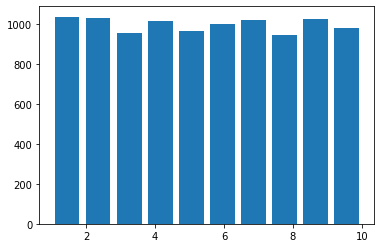

In [3]:
N=10000
n=10
p=[1/n for i in range(n)]
x=[i+1 for i in range(n)]
X=Discrete(p, x)
samples=X.generate(N)
plt.hist(samples, rwidth=0.8)

#Exercice 2

#Question 1
The parameters are the $(\mu_j, \Sigma_j)_{1\leq j \leq m}$ and the $(\alpha_j)_{1\leq j \leq m}$. The likelihood of our observations is defined as :
$$ \mathcal{L}(x_1,...,x_n;\theta) = q(x_1,...,x_n;\theta) = \prod_{i=1}^nq(x_i;\theta)$$
by independency. By conditioning on $Z_i$:
$$q(x_i;\theta) = \mathbb{E}_{Z_i}[q(x_i|Z_i;\theta)] = \sum_{j=1}^m \mathbb{P}(Z_i=j)q(x_i|Z_i=j;\theta)=\sum_{j=1}^m \alpha_j \mathcal{N}(\mu_j, \Sigma_j)(x_i)$$ 
Hence :
$$ \mathcal{L}(x_1,...,x_n;\theta) = \prod_{i=1}^n\sum_{j=1}^m \alpha_j \mathcal{N}(x_i|\mu_j, \Sigma_j)$$


#Question 2
We first decide from which class $z_i$ will be our sample $x_i$ with the discrete distribution using the first exercise, then we sample from a gaussian distribution with the parameters of the corresponding class.

In [112]:
class GaussianMixture():
  def __init__(self, alpha, mu, sigma):
    self.m=alpha.size
    self.alpha=alpha
    self.mu=mu
    self.sigma=sigma
    self.classes=Discrete(alpha, [j for j in range(self.m)])
  def generate(self, n=1):
    cl=self.classes.generate(n)
    return np.array([np.random.multivariate_normal(self.mu[cl[i]], self.sigma[cl[i]]) for i in range(n)])
  def density(self, x):
    return np.sum(np.array([self.alpha[j]*scipy.stats.multivariate_normal(self.mu[j], self.sigma[j]).pdf(x) for j in range(self.m)]))

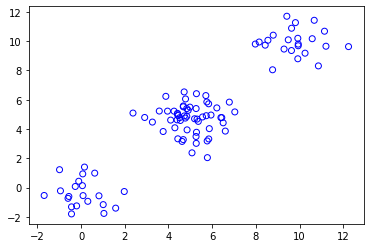

In [5]:
alpha = np.array([0.25, 0.5, 0.25])
mu = np.array([[0,0], [5, 5], [10,10]])
sigma = np.array([np.eye(2), np.eye(2), np.eye(2)])

n = 100
gm = GaussianMixture(alpha, mu, sigma)
samples = gm.generate(n)

plt.scatter(samples[:, 0], samples[:, 1], facecolors="None", edgecolors='b')

#Question 3

E-step : we want to derive $B(\theta, \theta_t)= \mathbb{E}_{q(z|x;\theta_t)}[\log(q(z, x; \theta))]$ with $\theta_t$ our parameter at step $t$ of the algorithm and $\theta$ the parameter to choose at step $t+1$.
Again let's condition on the  $(Z_i)_i$ and use Bayes' rule:
$$q(z, x; \theta) = q(x|z;\theta) q(z;\theta)$$
By using the independency of the $(X_i)_i$ and that expectation is a linear operation:
$$B(\theta, \theta_t)= \sum_{i=1}^n \mathbb{E}_{q(z_i|x_i;\theta_t)}[\log(q(x_i|z_i;\theta)) + \log(q(z_i;\theta))] $$
$$B(\theta, \theta_t)= \sum_{i=1}^n \sum_{j=1}^m \mathbb{P}(Z_i=j|X_i=x_i;\theta_t)(\log(\mathcal{N}(x_i|\mu_j, \Sigma_j)) + \log(\alpha_j)) $$

Let $p_{ij}^t = \mathbb{P}(Z_i=j|X_i=x_i;\theta_t)$. They can be inverted using Bayes' rule:
$$p_{ij}^t = \frac{q(x_i|z_i=j;\theta_t)q(z_i=j;\theta_t)}{q(x_i;\theta_t)} = \frac{\mathcal{N}(x_i|\mu_j^t, \Sigma_j^t)\alpha_j^t}{\sum_{j'=1}^m \alpha_{j'}^t\mathcal{N}(x_i|\mu_{j'}^t, \Sigma_{j'}^t)}$$

M-step: we want to maximize $B(\theta, \theta_t)$ w.r.t $\theta$. We shall derive w.r.t the $\mu_j, \Sigma_j$ and maximize w.r.t $\alpha_j$ (we can't derive directly because of the condition $\sum_j \alpha_j = 1$).
</br>
- $$ \frac{\partial{B}(\theta, \theta_t)}{\partial{\mu_j}} = \sum_ip_{ij}^t(-\Sigma_j^{-1}(x_i-\mu_j))=0$$

$\Sigma_j^{-1}$ is non-singular so we obtain that for every $j$, $\mu_j = \frac{\sum_i p_{ij}^t x_i}{\sum_i p_{ij}^t}$.
</br>
- $$ \frac{\partial{B}(\theta, \theta_t)}{\partial{\Sigma_j}} = \sum_ip_{ij}^t(\frac{\partial{-\frac{1}{2}\log(\det\Sigma_j})}{\partial{\Sigma_j}}+\frac{\partial{-\frac{1}{2}(x_i-\mu_j)^T\Sigma_j^{-1}(x_i-\mu_j)}}{\partial{\Sigma_j}})=0$$

For a matrix $A$ we have $\det(A)= \sum_{j} A_{ij}com(A)_{ij}$ for every $i$. When we take the derivative w.r.t. to $A_{i,j}$ it only remains $com(A)_{ij}$ in this sum. In matrix form: $\frac{\partial{\log(\det(A)})}{\partial{A}} = \frac{comA}{detA} = {A^T}^{-1} ={A}^{-1}$ when $A$ is symetric.
</br>
We also want to compute the derivative of $A → X^TA^{-1}X$ w.r.t. to $A$ for some vector $X$:
$$ AA^{-1} = I_d$$
$$\Longrightarrow \frac{\partial A}{\partial{A_{ij}}} A^{-1} + A \frac{\partial A^{-1}}{\partial{A_{ij}}} = 0$$
$$⟺ \frac{\partial A^{-1}}{\partial{A_{ij}}} = - A^{-1}E_{ij}A^{-1}$$
And then :
$$\frac{\partial X^TA^{-1}X}{\partial{A_{ij}}} = -X^TA^{-1}E_{ij}A^{-1}X$$
This is equivalent to the matrix form:
$$\frac{\partial X^TA^{-1}X}{\partial{A}} = -(X^TA^{-1})^T(A^{-1}X)^T$$
Using the symetricity of A:
$$\frac{\partial X^TA^{-1}X}{\partial{A}} = -A^{-1}XX^TA^{-1}$$
</br>
Combining all and using that $\Sigma_j$ is symmetric: $\Sigma_j^=\frac{\sum_i p_{ij}^t (x_i - \mu_j)(x_i - \mu_j)^T}{\sum_i p_{ij}^t }$
</br>
For the $(\alpha_j)_j$ we'll use the Lagrangian:
- $$\mathcal{L}(\lambda, (\alpha_j)_j) = \sum_i\sum_j p_{ij}^t \log\alpha_j + \lambda(1-\sum_j\alpha_j)$$

Derivating w.r.t. $\alpha_j$ we get $\lambda\alpha_j = \sum_i p_{ij}^t$. Taking the derivative w.r.t. $\lambda$ : $\sum_j \alpha_j = 1$ and using that for every $i$ $\sum_j p_{ij}^t = 1$ : $\alpha_j = \frac{\sum_i p_{ij}^t}{n}$.

In [11]:
class EM():
  
  def __init__(self, observations, m, params=None):
    self.x = observations
    self.n, self.d = observations.shape
    self.m=m
    if params:
      self.alpha = params[0]
      self.mu = params[1]
      self.sigma = params[2]
    else:
      self.init_params()
  
  def init_params(self):
    self.alpha = np.array([1/self.m for i in range(self.m)])
    self.mu = self.x[np.random.choice(range(self.n), size=self.m, replace=False)]
    mean = np.sum(self.x, axis=0)/self.n
    var = np.sum(np.linalg.norm(self.x-mean)**2)/self.n
    self.sigma = np.array([var*np.eye(self.d) for i in range(self.m)])
  
  def run(self, nb_iterations=100, plotting = True):
    self.init_params()
    p = np.zeros((self.n, self.m))
    lls = np.zeros(nb_iterations)
    for it in range(nb_iterations):
      #computing all the pij
      for i in range(self.n):
        q=0
        for j in range(self.m):
          p[i, j]= scipy.stats.multivariate_normal.pdf(self.x[i], self.mu[j], self.sigma[j])*self.alpha[j]
          q+=p[i, j]
        p[i] /= q
      #updating parameters
      self.alpha = (1/self.n)*np.array([np.sum(p[:, j]) for j in range(self.m)])
      self.mu = np.array([np.sum(np.array([p[i,j]*self.x[i] for i in range(self.n)]), axis=0)/(self.alpha[j]*self.n) for j in range(self.m)])
      self.sigma = np.array([np.sum(np.array([p[i,j]*np.outer(self.x[i]-self.mu[j],self.x[i]-self.mu[j]) for i in range(self.n)]), axis=0)/(self.alpha[j]*self.n) for j in range(self.m)])
      lls[it] = self.log_likelihood()
    if plotting:
      plt.plot(lls)
    return self.alpha, self.mu, self.sigma
  
  def log_likelihood(self):
    ans = 0
    for i in range(self.n):
      r = 0
      for j in range(self.m):
        r += scipy.stats.multivariate_normal.pdf(self.x[i], self.mu[j], self.sigma[j])*self.alpha[j]
      ans += np.log(r)
    return ans
  
  def contours(self, N=100):
    fig, ax = plt.subplots(1,1)
    ax.scatter(self.x[:,0], self.x[:,1], facecolors='None', edgecolors='b')
    xm, xM, ym, yM = self.x[:, 0].min()-2, self.x[:, 0].max()+2, self.x[:, 1].min()-2, self.x[:, 1].max()+2
    u=np.linspace(xm, xM, N)
    v=np.linspace(ym, yM, N)
    x,y = np.meshgrid(u, v)
    for j in range(self.m):
      z = scipy.stats.multivariate_normal(self.mu[j],self.sigma[j]).pdf(np.dstack((x, y)))
      ax.contour(u, v, z)
  
  def df(self):
    return self.m - 1 + self.d * self.m + self.d * (self.d + 1) // 2
  def bic(self):
    return -self.log_likelihood() + self.df()*np.log(n)/2
  
    

[0.22999986 0.56000014 0.21      ] [[ 9.76420977  9.92529959]
 [ 5.01130999  4.70473976]
 [ 0.07237624 -0.38323133]] [[[ 1.07031631  0.017698  ]
  [ 0.017698    0.77919599]]

 [[ 0.88320013 -0.04902186]
  [-0.04902186  0.95472997]]

 [[ 0.73864931 -0.13531035]
  [-0.13531035  0.87289786]]]


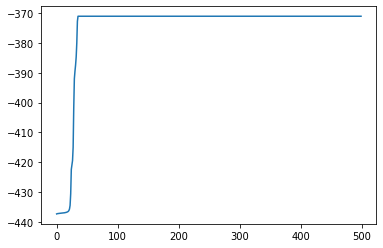

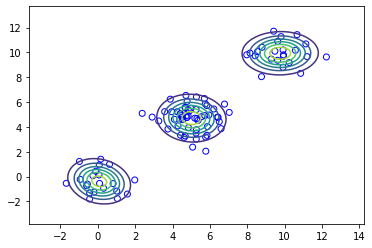

In [8]:
em = EM(samples, 3)
a,b,c = em.run(500)
print(a,b,c)
em.contours()

Above there is the log-likelihood curve given the steps, and just below we see the observations which have been overlapped with contours of the distributions computed by the EM algorithm.

#Question 4


Here we used as our Gaussian mixture three classes with respective probabilities $0.25, 0.5, 0.25$. We used $100$ observations. The estimated probabilities are $0.23, 0.56, 0,21$. This is quite close to the actual class probabilities. Furthemore, from the scatter plot with the contours above we see that the $means$ are well approximated in fact the actual $means$ are $(0, 0), (5, 5), (10, 10)$ and the approximated ones are $(0.07, -0.4), (5.0, 4.7), (9.7, 9.9)$. From the contours above we also see that the $covariance$ matrices are also well fitted to the observations. Overall the algorithm has great results and it could be even a bit more accurate with more observations.

#Question 5


In [9]:
data = pd.read_excel('data.xlsx', 0, names = ["Birth", "Death"], usecols="Z,AH", skiprows=16, na_values = ["...", np.inf], thousands=',')
data.head(10)

,Birth,Death
0,36.837,19.518
1,36.502,19.075
2,37.672,18.389
3,36.948,17.989
4,37.269,17.457
5,37.069,17.101
6,36.353,16.710
7,37.073,16.536
8,35.858,16.044
9,34.320,17.284


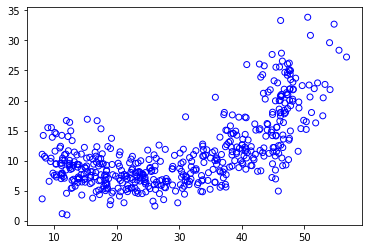

In [27]:
observations = data.to_numpy().astype(float)
n=observations.shape[0]
size = 500
observations = observations[np.random.choice(range(n), size = size, replace = False)]
plt.scatter(observations[:, 0], observations[:, 1], facecolors='None', edgecolors='b')

Just above we have plotted $500$ points of the dataset (more than $20000$ in total) with the birth rate horizontally and the death rate vertically.

Using a Gaussian mixture model could be a good idea. In fact using a mixture model implicitly assumes that there is a different class behind each sample. With this data we could easily imagine that the birth/death rate distribution varies a lot depending on the geographical context, social context, economical context... Moreover for modelling human behaviors it is often a good idea to take Gaussian distributions as the probability of being in the mean is high and being far from the mean is low.

#Question 6

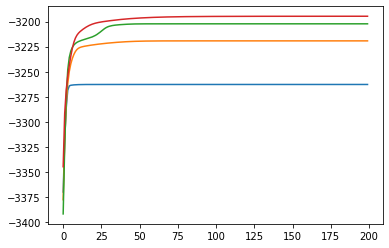

In [28]:
m_values = [2, 3, 4, 5]
ems = {m : EM(observations, m) for m in m_values}
bics = []
for m in m_values:
  ems[m].run(200)
  bics.append(ems[m].bic())

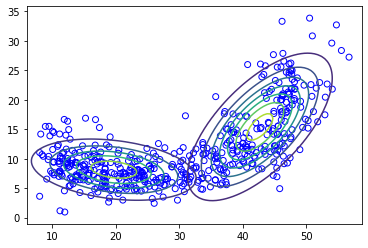

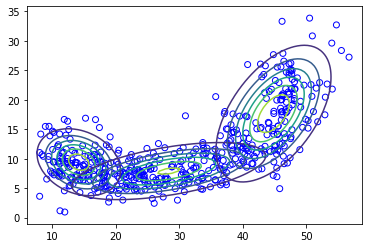

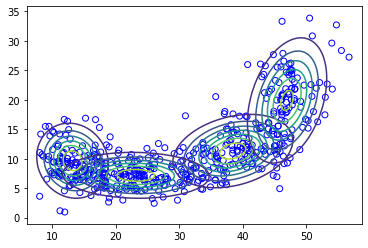

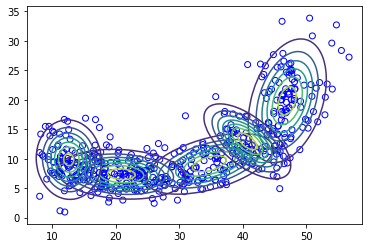

In [29]:
for m in m_values:
  ems[m].contours()

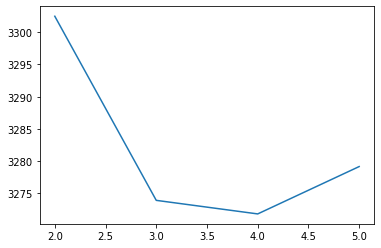

In [30]:
plt.plot(m_values, bics)

Above there are the contours of the Gaussian mixtures computed with EM with runs of the algorithm for $m$ in $2, 3, 4, 5$. Below there is the plot of the BIC for the same values of $m$.

 Here the BIC suggests to take $m=4$ but with another observation set(the observations have been chosen randomly from the whole dataset) we would sometimes get $m=3$ (in fact the BIC for $m=3$ is not far from the BIC for $m=4$). For different observation sets, the BIC has a shape similar to a parabola which simply mean we have to take models that have the ability to capture much information but that aren't too complex.
If we take a look at the contours obtained, the ones for $m=3,4$ are those who seem to meet this compromise. The one for $m=2$ isn't that bad however for $m=5$ the fourth cluster from the left seems to be artificial and doesn't seem to add information about some unrepresented class.

#Exercise 3

#Question 1

In [4]:
import numpy as np
import scipy.stats

In [44]:
mu, sigma2 = 0.8, 1.5
sigma = np.sqrt(sigma2)
N = 10000

@np.vectorize
def f(x):
  if x < 0:
    return 0
  else:
    return 2*np.sin(np.pi*x/sigma2)
@np.vectorize
def p(x):
  if x < 0:
    return 0
  else:
    return x**(1.65 - 1)*np.exp(-x**2/2)

@np.vectorize
def q(x):
  return scipy.stats.norm.pdf(x, loc=mu, scale=sigma)


def importance_sampling(N):
  samples = []
  n = 0
  while n < N:
    x = np.random.normal(mu, sigma)
    if x>=0:
      samples.append(x)
      n += 1

  weights = p(samples)/q(samples)
  normalized_weights = N*weights/np.sum(weights)
  ans = (1/N)*np.sum(normalized_weights*f(samples))
  return ans, weights

#Question 2

For $N=10$

In [46]:
N = 10
nb = 1000
estimates = np.array([importance_sampling(N)[0] for i in range(nb)])

mean = np.mean(estimates)
var = np.std(estimates)
print(mean, var)

0.7265461912265299 0.4000166646172204


For $N=100$

In [47]:
N = 100
nb = 500
estimates = np.array([importance_sampling(N)[0] for i in range(nb)])

mean = np.mean(estimates)
var = np.std(estimates)
print(mean, var)

0.7663969924374803 0.12366396533254713


For $N=1000$

In [48]:
N = 1000
nb = 100
estimates = np.array([importance_sampling(N)[0] for i in range(nb)])

mean = np.mean(estimates)
var = np.std(estimates)
print(mean, var)

0.7627986143814686 0.03789722868575303


For $N=10000$

In [49]:
N = 10000
nb = 10
estimates = np.array([importance_sampling(N)[0] for i in range(nb)])

mean = np.mean(estimates)
var = np.std(estimates)
print(mean, var)

0.7709622577662465 0.009124065165442376


We see that the variance is stronlgy decreasing as $N$ grows and the mean is stabilizing. For instance, with $N = 10^4$ we have a variance of $0.01$ for a mean of $0.77$ with only $10$ runs while for $N=10$ with $1000$ runs we have a variance of $0.4$ for a mean of $0.72$.

#Question 3

In [50]:
mu = 6
N = 10000
nb = 10
estimates = np.array([importance_sampling(N)[0] for i in range(nb)])

mean = np.mean(estimates)
var = np.std(estimates)
print(mean, var)

-0.29135878373823504 1.118680612740563


With $N=10000$ and with $10$ runs the estimate is clearly unreliable as the variance is almost four times the absolute value of the mean and the estimated mean is negative, which isn't true according to the curves(the area of the curve covered when the function is positive is greater than the one covered when the function is negative). So this really shows the importance of taking a good distribution for $q$ as well.
This is confirmed by the weights.

In [52]:
mu = 0.8
w = importance_sampling(N)[1]
print(w)

[1.40252979 1.55556624 1.92503051 ... 1.91741545 0.64827631 1.64886449]


In [53]:
mu = 6
w = importance_sampling(N)[1]
print(w)

[6.28601037e-05 1.43995839e-07 1.88897337e-07 ... 8.42610098e-08
 5.09679139e-06 1.27869040e-01]


Just above there are the importance weights of the importance sampling method in the case of $\mu = 0.8$ and $\mu = 6$. We clearly see that the first ones are very big compared to the second ones. This confirms the importance of sampling w.r.t. a distribution $q$ that has overlapping areas of strong density with $p$.

#Question 4

Let's see why we can use EM to solve step (iii). In fact we can write the problem as:
$$\theta^* = argmax_\theta \sum_i \tilde{w}_i^{(0)}log(q(X_i^{(0)}; \theta))$$
So we're here in a context where we can apply EM the only difference here is that each observation $X_i^{(0)}$has a different importance weight. Also to use EM we should assume that there exist latent random variables $Z_1^{(0)}, ...,Z_n^{(0)}$ that describe the class of each sample, as in Exercise 2.
</br>
- E-step : here we have $B(\theta_t, \theta_t) = \sum_i^n \tilde{w}_i^{(0)}\mathbb{E}_{f_t^i(z)}[log(q(X_i^{(0)}, Z; \theta_t)/f_t^i(Z))]$ that we should maximize w.r.t. some densities $(f_t^i(z))$. And because each of these terms can be maximized independently, the $(f_t^i(z))$ will the same as in the classic case.
</br>
- M-step: thus only the $p_{ij}^t$ will change, meaning:
$$p_{ij}^t ← \tilde{w}_i^{(0)} \cdot p_{ij}^t$$
Plus, the normalized weights sum up to $n$ so the updates on the $\alpha_j$ are unchanged.



#Question 5

In [188]:
class AdaptativeSampling():  
  def __init__(self, target_density, n_samples, dim, m, params=None):
    self.target_density = target_density
    self.n, self.d = n_samples, dim
    self.m=m
    if params:
      self.alpha = params[0]
      self.mu = params[1]
      self.sigma = params[2]
    else:
      self.init_params()
  
  def init_params(self):
    self.alpha = np.array([1/self.m for i in range(self.m)])
    self.mu = np.array([np.random.randn(self.d) for i in range(self.m)])
    self.sigma = np.array([np.eye(self.d) for i in range(self.m)])
  
  def run(self, nb_iterations_1=10, nb_iterations_2 = 20):
    def f(x):
      if x == 0:
        return 1
      else:
        return x
    #Population Monte Carlo algorithm to approximate the target density with a gaussian mixture
    self.init_params()
    p = np.zeros((self.n, self.m))
    w = np.zeros(self.n)
    X = np.zeros((self.n, self.d))

    for it1 in range(nb_iterations_1):
      print(it1)
      #step (ii)
      #we sample from our gaussian mixture
      gm = GaussianMixture(self.alpha, self.mu, self.sigma)
      q = 0
      for i in range(self.n):
        w[i] = 0
        while w[i] == 0:
          X[i] = gm.generate()
          w[i] = self.target_density(X[i])/gm.density(X[i])
        q += w[i]
      w *= (self.n/q)

      #step (iii)
      #we use EM to maximise the KL-divergence

      for it2 in range(nb_iterations_2):
        #computing all the pij
        for i in range(self.n):
          q=0
          for j in range(self.m):
            p[i, j]= scipy.stats.multivariate_normal.pdf(X[i], self.mu[j], self.sigma[j])*self.alpha[j]
            q+=p[i, j]
          p[i] /= q
          p[i] *= w[i]
        #updating parameters
        self.alpha = (1/self.n) * np.array([np.sum(p[:, j]) for j in range(self.m)])
        self.mu = np.array([np.sum(np.array([p[i,j]*X[i] for i in range(self.n)]), axis=0)/(self.alpha[j]*self.n) for j in range(self.m)])
        self.sigma = np.array([np.sum(np.array([p[i,j]*np.outer(X[i]-self.mu[j],X[i]-self.mu[j]) for i in range(self.n)]), axis=0)/(self.alpha[j]*self.n) for j in range(self.m)])
  def generate(self, n):
    gm = GaussianMixture(self.alpha, self.mu, self.sigma)
    return gm.generate(n)
  

In [231]:
d, sigma2, b = 2, 1, 0.4
def target_density(x):
  mean, Sigma = np.zeros(d), np.eye(d)
  Sigma[0, 0] = sigma2
  y = x
  y[1] += b*(y[0]**2 - sigma2)  
  return scipy.stats.multivariate_normal(mean, Sigma).pdf(y)

ads = AdaptativeSampling(target_density, 1000, d, 3)
ads.run(5)

0
1
2
3
4


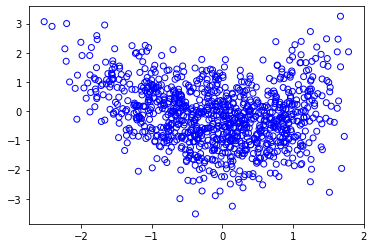

In [278]:
samples = ads.generate(1000)
x = np.array([sample[:2] for sample in samples])
plt.scatter(x[:, 0],x[:, 1], facecolors='None', edgecolors='b')
plt.show()

Here are $N = 1000$ samples drawn from the Gaussian Mixture that approaches the banana-density distribution.